In [28]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout,RandomFlip, RandomRotation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
fp ='dataset_1'
filepath= f'drive/MyDrive/{fp}'
shutil.copytree(filepath,fp)


'dataset_1'

In [32]:
!nvidia-smi

Thu May 12 00:21:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    35W / 250W |   8773MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [33]:
model_results = pd.DataFrame(columns=['Model Name','Validation Accuracy'])


In [34]:
def load_data(batch_size):
    training=keras.utils.image_dataset_from_directory(fp,
                                              batch_size=batch_size,
                                             validation_split =0.2,
                                             subset ='training',
                                             seed=42,
                                             image_size=(256,256),)
    val = keras.utils.image_dataset_from_directory(fp,
                                              batch_size=batch_size,
                                             validation_split =0.2,
                                             subset ='validation',
                                             seed=42,
                                             image_size=(256,256),)
    return training, val


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

In [36]:
batch_size= 32
training, val = load_data(batch_size)
training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val.cache().prefetch(buffer_size=AUTOTUNE)


Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
def conv_block(cnn,filters, depth=2,batchnorm =False, dropout=0.0):
    for i in range(depth):
        cnn.add(Conv2D(filters,(3,3),
                         padding='Same',
                         activation='relu',
                         kernel_initializer = 'he_uniform'))
        if batchnorm:
            cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D((2,2)))
    if dropout >0:
        cnn.add(Dropout(dropout))
    return cnn


##First Model

In [38]:
cnn = models.Sequential([layers.Rescaling(1./255,
                                           input_shape=(256,256,3))])
cnn = conv_block(cnn,64)
cnn=conv_block(cnn,128)
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128,activation='relu'))
cnn.add(layers.Dense(1,activation='sigmoid'))


In [39]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 128)     147584    
                                                      

In [40]:
lr = 0.001


opt=Adam(learning_rate=lr)
cnn.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [41]:

if not os.path.exists('drive/MyDrive/model_checkpoints'):
  os.mkdir('drive/MyDrive/model_checkpoints')

model_run = 'run1'
outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
if not os.path.exists(outpath):
  os.mkdir(outpath)
callbacks = [EarlyStopping(patience = 1,restore_best_weights=True),ModelCheckpoint(outpath,save_best_only=True)]



In [42]:
epochs = 10
history = cnn.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)

Epoch 1/10
128/128 [==============================] - 45s 349ms/step - loss: 2.7629 - accuracy: 0.5969 - val_loss: 0.6338 - val_accuracy: 0.6152
Epoch 2/10
128/128 [==============================] - 28s 216ms/step - loss: 0.6022 - accuracy: 0.6884 - val_loss: 0.6199 - val_accuracy: 0.6506
Epoch 3/10
128/128 [==============================] - 23s 182ms/step - loss: 0.5034 - accuracy: 0.7580 - val_loss: 0.6838 - val_accuracy: 0.7037


In [174]:
model_results=pd.concat([model_results,
           pd.DataFrame([[model_run,pd.DataFrame(history.history)['val_accuracy'].max()]],columns=['Model Name','Validation Accuracy'])],
  
           )

## Increase Model Size and Add Batchnorm and Dropout

In [175]:
epochs = 10
batch_size= 32
model_run = 'run2'
lr = 0.001

if not os.path.exists('drive/MyDrive/model_checkpoints'):
  os.mkdir('drive/MyDrive/model_checkpoints')

outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
if not os.path.exists(outpath):
  os.mkdir(outpath)
callbacks = [EarlyStopping(patience = 1,restore_best_weights=True),ModelCheckpoint(outpath,save_best_only=True)]


training, val = load_data(batch_size)
training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val.cache().prefetch(buffer_size=AUTOTUNE)


Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [176]:
cnn = models.Sequential([layers.Rescaling(1./255,
                                           input_shape=(256,256,3))])
cnn = conv_block(cnn,64,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,128,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,256,dropout=0.2,batchnorm=True)
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128,activation='relu'))
cnn.add(layers.Dense(1,activation='sigmoid'))



opt=Adam(learning_rate=lr)
cnn.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [177]:

history = cnn.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)

Epoch 1/10
128/128 [==============================] - 90s 290ms/step - loss: 6.2693 - accuracy: 0.5932 - val_loss: 0.7907 - val_accuracy: 0.5089
Epoch 2/10
128/128 [==============================] - 34s 259ms/step - loss: 0.6020 - accuracy: 0.6793 - val_loss: 4.5231 - val_accuracy: 0.4242


In [ ]:
pd.DataFrame(history.history).plot()


In [ ]:
model_results=pd.concat([model_results,
           pd.DataFrame([[model_run,pd.DataFrame(history.history)['val_accuracy'].max()]],columns=['Model Name','Validation Accuracy'])],
  
           )

In [46]:
def augment(flip =True, rotation= 0.1):
  aug = models.Sequential()
  if flip:
    aug.add(RandomFlip('horizontal'))
  if rotation >0:
    aug.add(RandomRotation(rotation))
  return aug

## Add Data Augmentation. Increase Network Capacity

In [50]:
epochs = 10
model_run = 'run3'
lr = 0.001

if not os.path.exists('drive/MyDrive/model_checkpoints'):
  os.mkdir('drive/MyDrive/model_checkpoints')

outpath = os.path.join('drive/MyDrive/model_checkpoints',model_run)
if not os.path.exists(outpath):
  os.mkdir(outpath)
callbacks = [EarlyStopping(patience = 1,restore_best_weights=True),ModelCheckpoint(outpath,save_best_only=True)]



training, val = load_data(batch_size)
training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val.cache().prefetch(buffer_size=AUTOTUNE)

Found 5082 files belonging to 2 classes.
Using 4066 files for training.
Found 5082 files belonging to 2 classes.
Using 1016 files for validation.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [48]:
cnn = models.Sequential([layers.Rescaling(1./255,
                                           input_shape=(256,256,3))])
cnn.add(augment())
cnn = conv_block(cnn,64,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,128,dropout=0.2,batchnorm=True)
cnn=conv_block(cnn,256,depth=4,dropout=0.2,batchnorm=True)
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='relu'))
cnn.add(layers.Dense(1,activation='sigmoid'))

cnn.summary()

opt=Adam(learning_rate=lr)
cnn.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 64)     256       
 hNormalization)                                      

In [51]:
history = cnn.fit(training, validation_data=val,epochs=epochs,callbacks = callbacks)

Epoch 1/10
128/128 [==============================] - 49s 379ms/step - loss: 0.5355 - accuracy: 0.7309 - val_loss: 0.5591 - val_accuracy: 0.7323
Epoch 2/10
128/128 [==============================] - 41s 318ms/step - loss: 0.5160 - accuracy: 0.7479 - val_loss: 0.5710 - val_accuracy: 0.7195


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predictions,labels,p=0.5):
  cm=confusion_matrix(labels, predictions>p)
  sns.heatmap(cm,annot=True,fmt ='d',xticklabels=['People','Weapon'],yticklabels=['People','Weapon'])
  plt.title(f'p>{p}')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')

def get_predictions(model,data):
  """Expects a TF Dataset"""
  predicted=[]
  labels=[]
  for x, y in data:
    predicted.append(model.predict(x))
    labels.append(y)

  
  return np.concatenate(predicted), np.concatenate(labels)


In [84]:
train_preds, train_labels = get_predictions(cnn,training)
#train_X, train_y = get_features_and_labels(training)
#training_preds = cnn.predict(train_X,batch_size=batch_size)

### Train confusion matrix

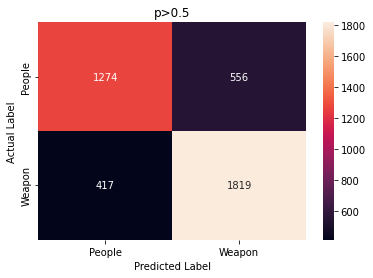

In [86]:
plot_confusion_matrix(train_preds, train_labels)

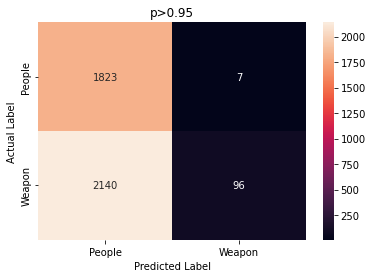

In [87]:
plot_confusion_matrix(train_preds, train_labels,p=0.95)

### Test Confusion matrix

In [88]:
test_preds, test_labels = get_predictions(cnn,val)

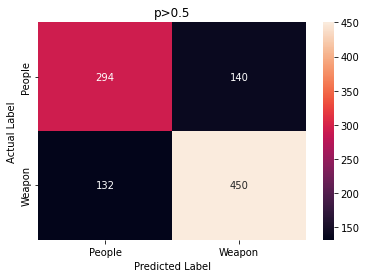

In [89]:
plot_confusion_matrix(test_preds, test_labels)

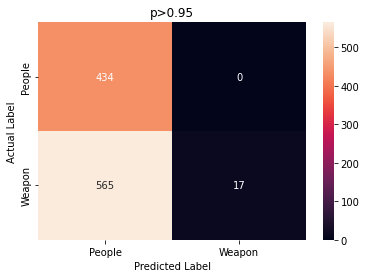

In [90]:
plot_confusion_matrix(test_preds, test_labels,p=0.95)